# MNIST Fashion Neural Network

In [0]:
import torch
import matplotlib.pyplot as plt

## Loading Dataset

In [2]:
from torchvision import datasets, transforms

transform = transforms.Compose([
  transforms.ToTensor(), 
  transforms.Normalize((0.5, ), (0.5, ))
])

trainset = datasets.FashionMNIST(
    "MNIST/", 
    download=True, 
    train=True, 
    transform=transform
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


Extracting MNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST/FashionMNIST/raw



Extracting MNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST/FashionMNIST/raw



Extracting MNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/FashionMNIST/raw



Extracting MNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/FashionMNIST/raw
Processing...
Done!


In [0]:
images, labels = iter(trainloader).next()

In [4]:
images.shape

torch.Size([64, 1, 28, 28])

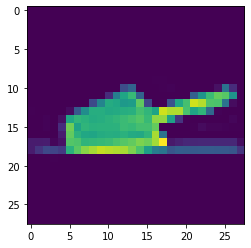

In [5]:
plt.imshow(images[2].numpy().squeeze())

In [0]:
images = images.view(images.shape[0], -1)

In [7]:
images.shape

torch.Size([64, 784])

In [8]:
labels

tensor([0, 7, 5, 0, 1, 5, 7, 4, 6, 0, 1, 2, 9, 2, 7, 7, 7, 9, 8, 6, 9, 4, 3, 2,
        9, 8, 3, 0, 1, 2, 8, 9, 9, 9, 0, 7, 9, 2, 1, 2, 7, 0, 2, 4, 0, 8, 6, 7,
        1, 4, 1, 5, 6, 3, 4, 1, 6, 2, 5, 0, 2, 0, 2, 9])

# Building Neural Network

In [0]:
from torch import nn, optim

model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
)

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)
epochs = 5

# Training Model

In [10]:
for i in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    images = images.view(images.shape[0], -1)

    optimizer.zero_grad()

    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  else:
    print(f"Training Loss: {running_loss/len(trainloader)}")

Training Loss: 1.658138822708557
Training Loss: 0.8715330794421848
Training Loss: 0.6939665821950827
Training Loss: 0.6213310816204116
Training Loss: 0.574760781771847


# Predictions

In [11]:
images, labels = iter(trainloader).next()

with torch.no_grad():
  output = model.forward(images[0].view(1, 784))

output

tensor([[ -7.1109,  -0.0502,  -7.6463,  -3.0854,  -6.3478, -11.8095,  -8.5404,
         -15.7427, -11.9088, -13.7309]])

In [0]:
import torch.nn.functional as F
import numpy as np

probabilities = F.softmax(output, dim=1)
prediction = np.argmax(probabilities)

In [13]:
prediction.item()

1

In [14]:
prediction.item() == labels[0].item()

True

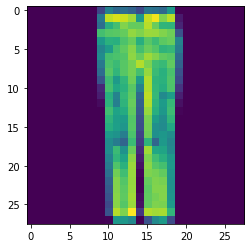

In [15]:
plt.imshow(images[0].numpy().squeeze())

## Saving and Loading Model

In PyTorch, we save the `state_dict()` which holds all the parameters (weights and bias) of the model. We can do this using `torch.save()` We can load the `state_dict()` back using `torch.load()`, but then we have to load this `state_dict()` into the model using `load_state_dict()`.

In [0]:
torch.save(model.state_dict(), "checkpoint.pth")

In [23]:
state_dict = torch.load("checkpoint.pth")
state_dict.keys()

odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])

In [24]:
model.load_state_dict(state_dict)

<All keys matched successfully>

This will have a `RuntimeError` now because the `state_dict` you tried to load has a shape of `[128, 784]`. This new model has shape of `[10, 784]`, so we have a size mismatch. 

**Solution:** Store more information than the `state_dict()` in the checkpoint

In [0]:
model = nn.Sequential(
    nn.Linear(784, 10),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
)

# model.load_state_dict(state_dict)

In [0]:
checkpoint = {
    "input_size": 784,
    "output_size": 10,
    # "hidden_layers": [layer.out_features for layer in model.hidden_layers],
    "state_dict": model.state_dict()
}

torch.save(checkpoint, "checkpoint.pth")